In [1]:
# ─── 0) ADDITIONAL IMPORT ────────────────────────────────────────────────────
from concurrent.futures import ThreadPoolExecutor

# ─── 1) IMPORTS & STYLE ────────────────────────────────────────────────────
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

from glob                                import glob
from sklearn.linear_model                import LogisticRegression
import statsmodels.api                   as sm
from statsmodels.genmod.families         import Gamma
from statsmodels.genmod.families.links   import Log as loglink

plt.style.use("ggplot")

# ─── 2) FIND FILE LISTS ────────────────────────────────────────────────
orig_files = sorted(glob("sample_orig_*.txt"))
svc_files  = sorted(glob("sample_svcg_*.txt"))
if not orig_files or not svc_files:
    raise FileNotFoundError("Make sure sample_orig_*.txt and sample_svcg_*.txt are in your cwd")

# ─── 3) COLUMN NAMES ────────────────────────────────────────────────────────
orig_cols = [
    "CREDIT_SCORE","FIRST_PAYMENT_DATE","FIRST_TIME_HOMEBUYER_FLAG","MATURITY_DATE",
    "MSA","MI_PERCENT","NUM_UNITS","OCCUPANCY_STATUS","ORIG_CLTV","ORIG_DTI","ORIG_UPB",
    "ORIG_LTV","ORIG_INTEREST_RATE","CHANNEL","PPM_FLAG","AMORT_TYPE","PROP_STATE",
    "PROP_TYPE","POSTAL_CODE","LOAN_SEQ","LOAN_PURPOSE","ORIG_TERM","NUM_BORROWERS",
    "SELLER_NAME","SERVICER_NAME","SUPER_CONFORM_FLAG","PRE_RELIEF_LSN",
    "PROGRAM_IND","RELIEF_REFI_IND","PROP_VAL_METHOD","IO_IND","MI_CANCEL_IND"
]
svc_cols = [
    "LOAN_SEQ","PERIOD","CUR_ACTUAL_UPB","CUR_DELINQ_STATUS","LOAN_AGE",
    "REMAIN_MONTHS","DEFECT_SETTLE_DATE","MOD_FLAG","ZERO_BALANCE_CODE",
    "ZERO_BALANCE_DATE","CUR_INTEREST_RATE","CUR_NON_INT_UPB","DDLPI","MI_RECOV",
    "NET_SALE_PROCS","NON_MI_RECOV","TOTAL_EXPENSES","LEGAL_COSTS",
    "MAINT_PRES_COSTS","TAXES_INS","MISC_EXPENSES","ACTUAL_LOSS","CUM_MOD_COST",
    "STEP_MOD_FLAG","PAYMENT_DEFERRAL","ELTV","ZB_REMOVAL_UPB",
    "DELINQ_ACCRUED_INT","DISASTER_FLAG","BORROWER_ASSIST_CODE",
    "CUR_MONTH_MOD_COST","INT_BEARING_UPB"
]

# ─── 4) PARALLEL READ + CONCAT ───────────────────────────────────────────────
def _read(path, cols):
    return pd.read_csv(path, sep="|", header=None, names=cols, dtype=str)

with ThreadPoolExecutor() as exe:
    orig_dfs = list(exe.map(lambda f: _read(f, orig_cols), orig_files))
    svc_dfs  = list(exe.map(lambda f: _read(f, svc_cols), svc_files))

orig_df = pd.concat(orig_dfs, ignore_index=True)
svc_df  = pd.concat(svc_dfs,  ignore_index=True)

In [5]:
# ─── 3) PARSE DATES & CAST NUMERIC FIELDS ───────────────────────────────
orig_df["FIRST_PAYMENT_DATE"] = pd.to_datetime(orig_df["FIRST_PAYMENT_DATE"], format="%Y%m", errors="coerce")
orig_df["MATURITY_DATE"]      = pd.to_datetime(orig_df["MATURITY_DATE"],      format="%Y%m", errors="coerce")
svc_df ["PERIOD"]             = pd.to_datetime(svc_df ["PERIOD"],             format="%Y%m", errors="coerce")

num_fields_svc  = ["CUR_ACTUAL_UPB","ZB_REMOVAL_UPB","DELINQ_ACCRUED_INT",
                   "NET_SALE_PROCS","MI_RECOV","NON_MI_RECOV","TOTAL_EXPENSES",
                   "LOAN_AGE","ELTV","CUR_INTEREST_RATE"]
num_fields_orig = ["ORIG_UPB","ORIG_LTV","ORIG_DTI","ORIG_INTEREST_RATE","ORIG_TERM"]

svc_df [num_fields_svc ] = svc_df [num_fields_svc ].apply(pd.to_numeric, errors="coerce")
orig_df[num_fields_orig] = orig_df[num_fields_orig].apply(pd.to_numeric, errors="coerce")


# ─── 4) BUILD PANEL & DTV ────────────────────────────────────────────────
orig_sub = orig_df[["LOAN_SEQ","ORIG_UPB","ORIG_LTV","ORIG_DTI"]]
panel    = svc_df.merge(orig_sub, on="LOAN_SEQ", how="left")
panel["DTV"] = panel["CUR_ACTUAL_UPB"] / ((panel["ELTV"] / 100) * panel["ORIG_UPB"])

In [7]:
# ─── 5) TERMINATION RECORDS & LOSS AMOUNT ───────────────────────────────
term_codes = {"02","03","09","16","96"}        # paid‐off, foreclosure, REO, etc.
disp = panel[panel["ZERO_BALANCE_CODE"].isin(term_codes)].copy()

disp["LOSS_AMT"] = (
      disp["ZB_REMOVAL_UPB"].fillna(0)
    + disp["DELINQ_ACCRUED_INT"].fillna(0)
    - disp["NET_SALE_PROCS"].fillna(0)
    - disp["MI_RECOV"].fillna(0)
    - disp["NON_MI_RECOV"].fillna(0)
    - disp["TOTAL_EXPENSES"].fillna(0)
)
disp["LOSS_ZERO"] = (disp["LOSS_AMT"] == 0)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               LOSS_AMT   No. Observations:                  680
Model:                            GLM   Df Residuals:                      675
Model Family:                   Gamma   Df Model:                            4
Link Function:                    Log   Scale:                         0.37296
Method:                          IRLS   Log-Likelihood:                -9088.0
Date:                Mon, 05 May 2025   Deviance:                       285.76
Time:                        18:04:44   Pearson chi2:                     252.
No. Iterations:                    11   Pseudo R-squ. (CS):            0.09121
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.5623      0.15

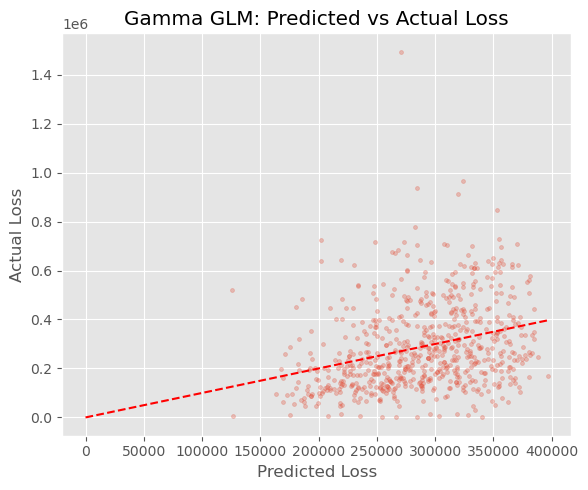

In [9]:
# ─── 6) LGD FEATURE SET ─────────────────────────────────────────────────
lgd_features = ["ORIG_LTV","DTV","LOAN_AGE","CUR_INTEREST_RATE","ORIG_DTI"]
lgd_df = disp[["LOAN_SEQ","PERIOD"] + lgd_features + ["LOSS_ZERO","LOSS_AMT","CUR_ACTUAL_UPB","ZB_REMOVAL_UPB"]].dropna()


# ─── 7) STAGE 1 — ZERO-LOSS CLASSIFIER ──────────────────────────────────
X0 = lgd_df[lgd_features].astype(float)
y0 = lgd_df["LOSS_ZERO"].astype(int)

if y0.nunique() > 1:
    clf0 = LogisticRegression(solver="liblinear").fit(X0, y0)
    lgd_df["P_zero"] = clf0.predict_proba(X0)[:, 1]
else:
    lgd_df["P_zero"] = 0.0
lgd_df["P_pos"] = 1.0 - lgd_df["P_zero"]


# ─── 8) STAGE 2 — GAMMA GLM ON POSITIVE LOSSES ──────────────────────────
pos = lgd_df[~lgd_df["LOSS_ZERO"]].copy().assign(Intercept=1.0)

glm = sm.GLM(
    endog = pos["LOSS_AMT"],
    exog  = pos[["Intercept"] + lgd_features],
    family = Gamma(link=loglink())
).fit()

print(glm.summary())

preds = glm.predict(pos[["Intercept"] + lgd_features])
plt.figure(figsize=(6, 5))
plt.scatter(preds, pos["LOSS_AMT"], s=8, alpha=0.3)
plt.plot([0, preds.max()], [0, preds.max()], "r--")
plt.title("Gamma GLM: Predicted vs Actual Loss")
plt.xlabel("Predicted Loss");  plt.ylabel("Actual Loss")
plt.tight_layout()
plt.show()

pos["mu"] = preds

In [11]:
# ─── 9) MERGE LGD COMPONENTS & COMPUTE LGD_pred ─────────────────────────
disp = (
    disp
    .merge(lgd_df[["LOAN_SEQ","PERIOD","P_pos"]], on=["LOAN_SEQ","PERIOD"], how="left")
    .merge(pos   [["LOAN_SEQ","PERIOD","mu"   ]], on=["LOAN_SEQ","PERIOD"], how="left")
)
disp["mu"] = disp["mu"].fillna(0.0)
disp["ELG"] = disp["P_pos"] * disp["mu"]

# ► FIX: divide by UPB AT REMOVAL, not by zero current balance
base_upb = disp["ZB_REMOVAL_UPB"].replace({0: np.nan})
disp["LGD_pred"] = (disp["ELG"] / base_upb).fillna(0.0)

In [13]:
# ───10) PD TARGET (12-MONTH LOOK-AHEAD) ─────────────────────────────────
pan2 = panel.copy()
pan2["DQ_NUM"] = pd.to_numeric(pan2["CUR_DELINQ_STATUS"], errors="coerce").fillna(0)
pan2 = pan2.sort_values(["LOAN_SEQ","PERIOD"])

pan2["FWD_MAX_DQ"] = (
    pan2.groupby("LOAN_SEQ")["DQ_NUM"]
        .apply(lambda x: x[::-1].rolling(12, min_periods=1).max()[::-1].shift(-1).fillna(0))
        .reset_index(level=0, drop=True)
)
pan2["PD_TARGET"] = (pan2["FWD_MAX_DQ"] >= 2).astype(int)

pd_features = ["ORIG_LTV","DTV","LOAN_AGE","CUR_INTEREST_RATE","ORIG_DTI","CUR_ACTUAL_UPB"]
pd_df = pan2[["LOAN_SEQ","PERIOD"] + pd_features + ["PD_TARGET"]].dropna()

In [15]:
# ───11) PD MODEL (LOGIT) ────────────────────────────────────────────────
X1 = pd_df[pd_features].astype(float)
y1 = pd_df["PD_TARGET"].astype(int)

if y1.nunique() > 1:
    clf1 = LogisticRegression(max_iter=1000).fit(X1, y1)
    pd_df["PD12"] = clf1.predict_proba(X1)[:, 1]
else:
    pd_df["PD12"] = 0.0

In [21]:
# ───12) COMBINE PD × LGD → 12-MONTH EXPECTED LOSS ───────────────────────
el_df = (
    disp[["LOAN_SEQ","PERIOD","LGD_pred"]]
    .merge(pd_df[["LOAN_SEQ","PERIOD","PD12"]], on=["LOAN_SEQ","PERIOD"], how="inner")
)
el_df["EL_12M"] = el_df["PD12"] * el_df["LGD_pred"]

print(el_df.head())

       LOAN_SEQ     PERIOD  LGD_pred      PD12    EL_12M
0  F20Q10003649 2020-08-01  2.726783  0.021535  0.058721
1  F20Q10007961 2021-05-01  0.934397  0.014782  0.013813
2  F20Q10015383 2024-01-01  0.822973  0.005441  0.004478
3  F20Q10022659 2020-08-01  2.007064  0.006306  0.012657
4  F20Q10029760 2024-03-01  0.880807  0.010818  0.009528


PD Model AUC: 0.6164


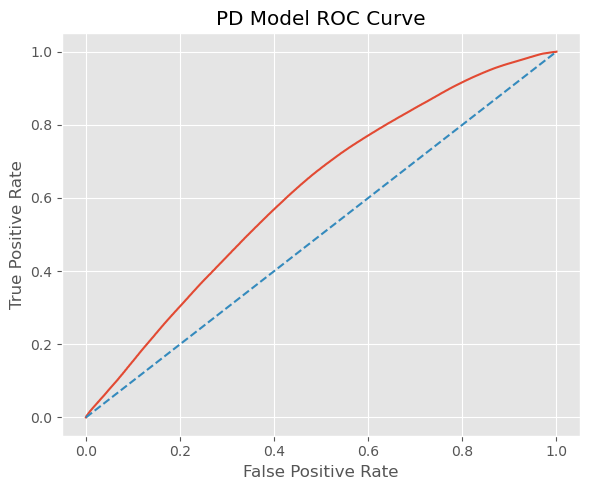

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

# 1) True labels and predicted probabilities
y_true = y1               # your pd_df["PD_TARGET"]
y_scores = clf1.predict_proba(X1)[:, 1]

# 2) ROC curve & AUC
fpr, tpr, _   = roc_curve(y_true, y_scores)
roc_auc       = auc(fpr, tpr)
print(f"PD Model AUC: {roc_auc:.4f}")

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.title("PD Model ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()

In [25]:
# ─── 13) DOLLAR ECL PER LOAN ─────────────────────────────────────────────
# First, grab an exposure field for each loan-period.
# Here we'll use the last non-zero principal before removal:
panel["PREV_UPB"] = (
    panel
    .sort_values(["LOAN_SEQ","PERIOD"])
    .groupby("LOAN_SEQ")["CUR_ACTUAL_UPB"]
    .shift(1)
)

# Merge EL_12M back onto the full panel
ecl_df = (
    el_df
    .merge(panel[["LOAN_SEQ","PERIOD","PREV_UPB","ZB_REMOVAL_UPB"]],
           on=["LOAN_SEQ","PERIOD"], how="left")
    .rename(columns={"PREV_UPB":"EAD_prev", "ZB_REMOVAL_UPB":"EAD_removal"})
)

# Compute dollar ECL two ways:
#  - ECL_prev uses the period-t UPB
#  - ECL_rem uses the removal UPB
ecl_df["ECL_prev"]   = ecl_df["EL_12M"] * ecl_df["EAD_prev"]
ecl_df["ECL_removal"]= ecl_df["EL_12M"] * ecl_df["EAD_removal"]

print(ecl_df[["LOAN_SEQ","PERIOD","EL_12M","EAD_prev","ECL_prev",
              "EAD_removal","ECL_removal"]].head())


       LOAN_SEQ     PERIOD    EL_12M   EAD_prev     ECL_prev  EAD_removal  \
0  F20Q10003649 2020-08-01  0.058721  130000.00  7633.684305    130000.00   
1  F20Q10007961 2021-05-01  0.013813  308002.30  4254.342631    308002.30   
2  F20Q10015383 2024-01-01  0.004478  154252.34   690.669043    154252.34   
3  F20Q10022659 2020-08-01  0.012657   97000.00  1227.709022     97000.00   
4  F20Q10029760 2024-03-01  0.009528  261015.44  2487.051310    261015.44   

   ECL_removal  
0  7633.684305  
1  4254.342631  
2   690.669043  
3  1227.709022  
4  2487.051310  


In [27]:
from sklearn.metrics import (
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    classification_report
)

# 1) PD‐stage AUC
pd_auc = roc_auc_score(y1, clf1.predict_proba(X1)[:,1])
print(f"PD AUC: {pd_auc:.4f}")

# 2) LGD RMSE & MAE
lgd_rmse = mean_squared_error(pos["LOSS_AMT"], preds, squared=False)
lgd_mae  = mean_absolute_error(pos["LOSS_AMT"], preds)
print(f"LGD RMSE: {lgd_rmse:.2f}, MAE: {lgd_mae:.2f}")

# 3) EL/ECL RMSE
eval_df = (
    el_df
    .merge(disp[["LOAN_SEQ","PERIOD","LOSS_AMT"]], on=["LOAN_SEQ","PERIOD"], how="left")
    .fillna({"LOSS_AMT":0})
    .rename(columns={"LOSS_AMT":"actual_loss","EL_12M":"predicted_EL"})
)
ecl_rmse = mean_squared_error(eval_df.actual_loss, eval_df.predicted_EL, squared=False)
print(f"ECL RMSE: {ecl_rmse:.2f}")

PD AUC: 0.6164
LGD RMSE: 168912.50, MAE: 129824.76
ECL RMSE: 338224.35


C:\Users\peter\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\peter\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
